In [1]:
import census
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import time

Start off by loading up datasets and doing any preprocessing

In [2]:
oData = pd.read_pickle("condo_prices_report.pkl")
cData = pd.read_pickle("condo_prices_report.pkl")
gentrified = pd.read_csv("kmeans_gentrified.csv")
#non_gentrified = pd.read_csv("data_eligible_not_09_18.csv")
#gentrified_geoids = gData.geoid.values

# Remove block number for geoid
cData.geoid = cData.geoid.apply(lambda x: int(str(x)[:-4])) 
oData.geoid = oData.geoid.apply(lambda x: int(str(x)[:-4])) 

# Obtain condo-value data for condos in gentrified and non gentrified areas
nData = cData[~cData.geoid.isin(gentrified.geoid.unique())] # Non gentrified condos
cData = cData[cData.geoid.isin(gentrified.geoid.unique())] # Gentrified condos

# All gentrified geoids are in Manhattan only. We only compare gentrified and non-gentrified geoid prices in Manhattan, none of the other borough are included

In [3]:
years = np.arange(2012, 2019)

stats = {}

# Find mean, median and std of prices for condos each year
for geoid in unique_geoids:
    stats[geoid] = []
    for year in years:
        stat = {}
        vals = cData[(cData.geoid == geoid) & (cData.report_year == year)].market_value_per_sqft.values
        if len(vals) > 0:
            stat["std"] = np.std(vals)
            stat["mean"] = np.mean(vals)
            stat["median"] = np.median(vals)
        else:
            stat["std"] = 0
            stat["mean"] = 0
            stat["median"] = 0
        stats[geoid].append(stat)
        

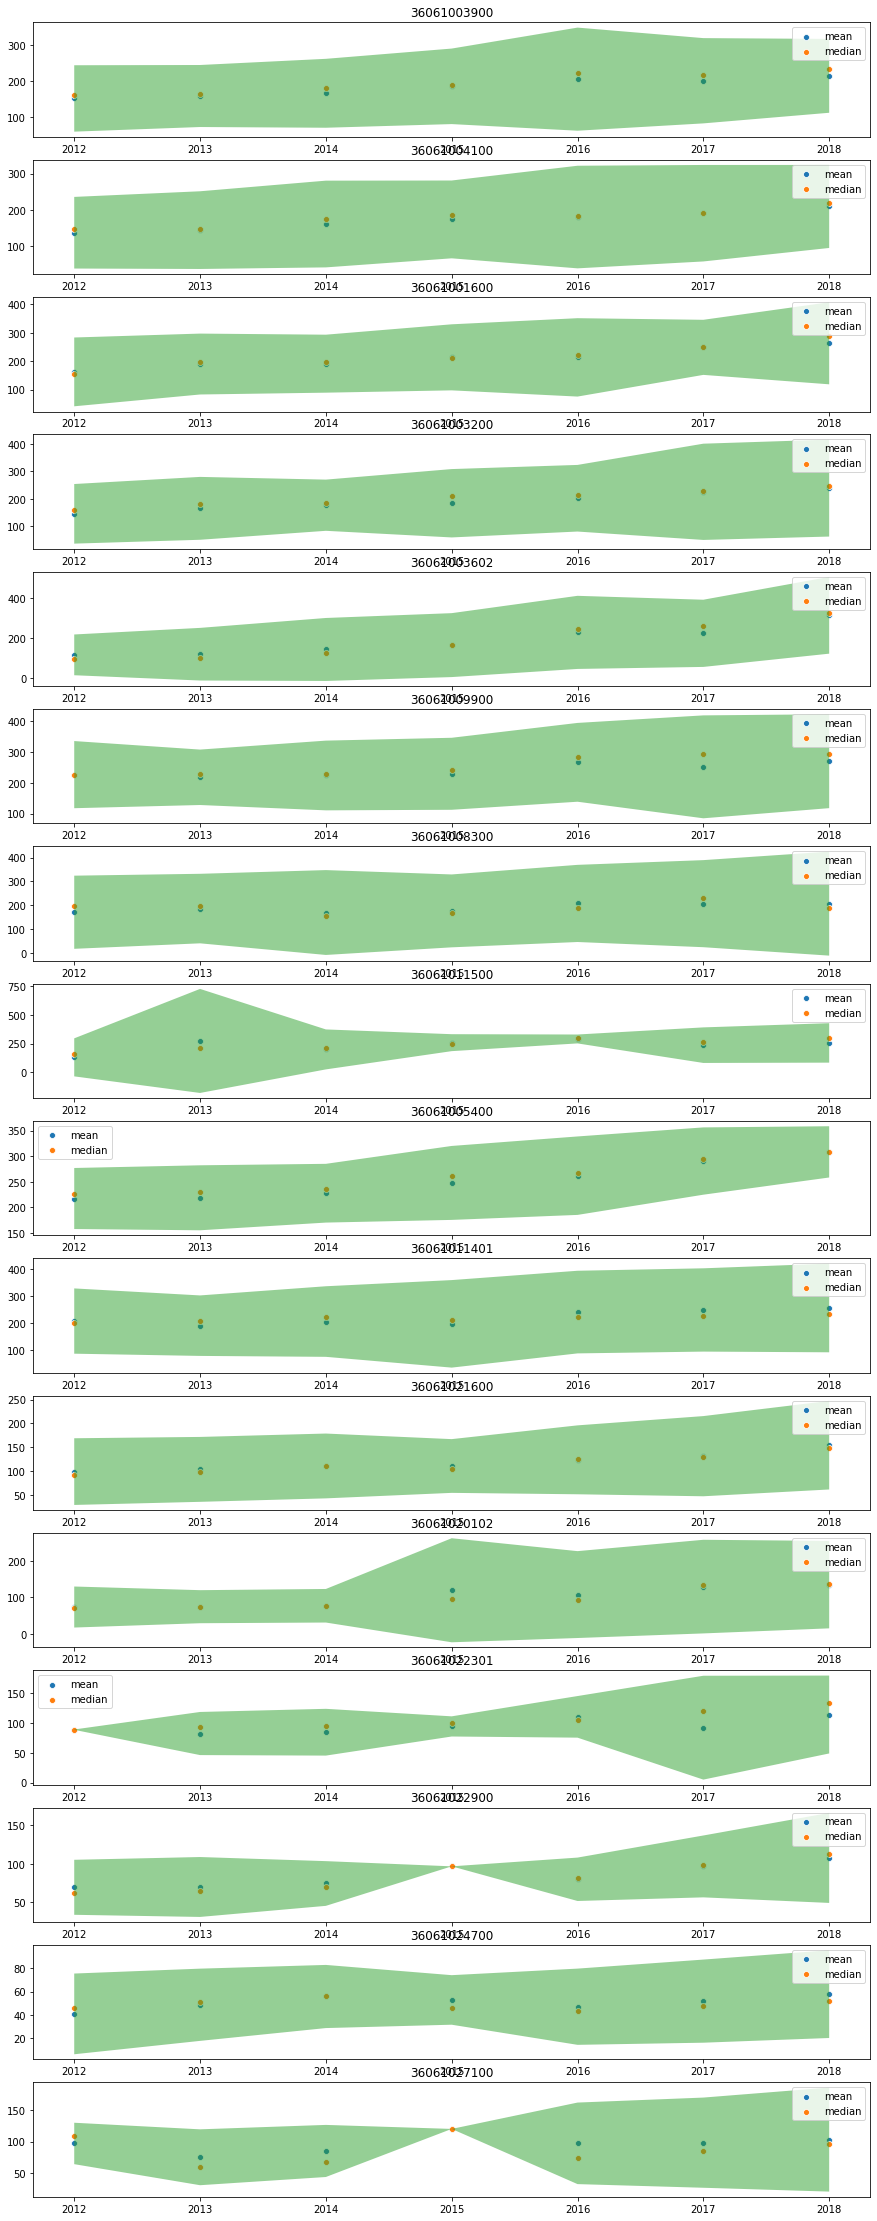

In [5]:
# Plot mean, median and 2*std of prices of condos in each geoid

fig, ax = plt.subplots(len(unique_geoids), 1, figsize=(15, 40))
plotter = lambda x, key: np.array([i[key] for i in x])
for i, geoid in enumerate(unique_geoids):
    mean = plotter(stats[geoid], "mean")
    sns.scatterplot(years, mean, ax=ax[i], label="mean")
    sns.scatterplot(years, plotter(stats[geoid], "median"), ax=ax[i], label="median")
    std = plotter(stats[geoid], "std")
    ax[i].fill_between(years, mean+2*std, mean-2*std, alpha=0.5, label="2std")
    ax[i].set_title(geoid)

In [6]:
ugeoids = unique_geoids
changes = []
medchanges = []

# Extract the mean and median condo prices year on year and the % change for each

# % change year on year
for ug in ugeoids:
    mean = plotter(stats[ug], "mean")
    median = plotter(stats[ug], "median")
    pct_change = np.diff(mean) / mean[1:]
    changes.append(pct_change)
    pct_change = np.diff(median) / median[1:]
    medchanges.append(pct_change)

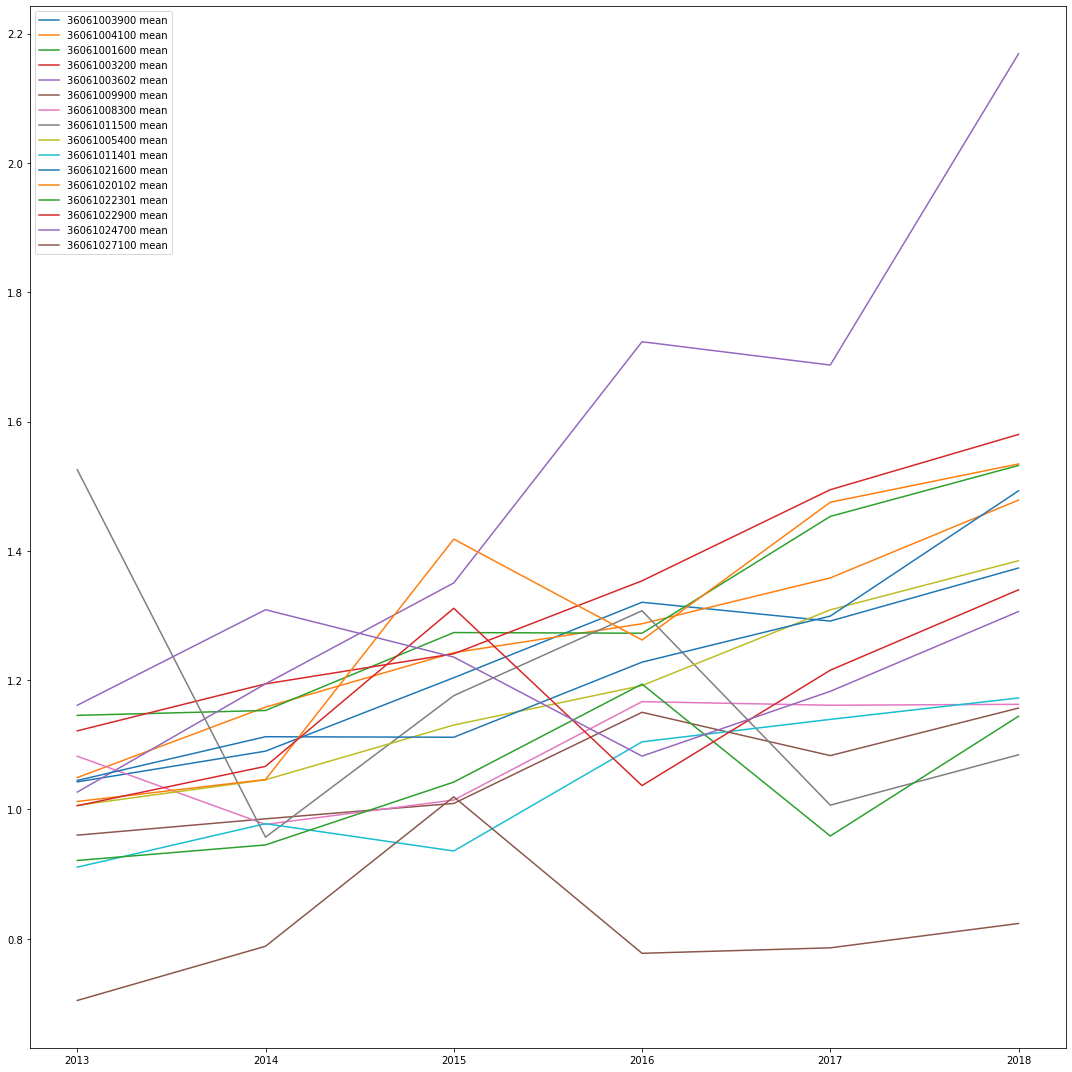

In [8]:
# Plot the mean and median cumulative % change in price
# Starts from some % not 1 and haven't bothered with replacing nan in 2012
fig, ax = plt.subplots(figsize=(15, 15))
cum_pct = []
med_cum_pct = []

for a, g, m in zip(changes, ugeoids, medchanges):
    cum_pct.append((a+1).cumprod())
    med_cum_pct.append((m+1).cumprod())
    ax.plot(years[1:], (a+1).cumprod(), label=str(g)+" mean")
    #ax.plot(years[1:], (m+1).cumprod(), label=str(g)+" median")
    ax.legend()
plt.tight_layout()

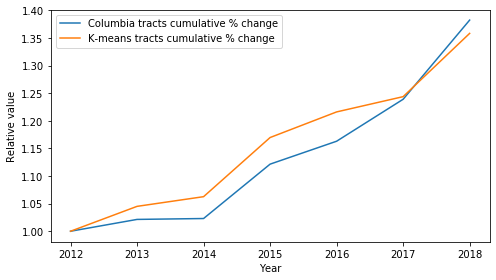

In [33]:
# Plot the mean and median cumulative % change for all gentrified geoids
p1 = [1.0, 1.02143312, 1.02305258, 1.12155984, 1.16308422, 1.23909093, 1.3825385 ]
p2 = np.insert(np.mean(cum_pct, axis=0), 0, 1.0)
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(years, np.array(p1), label="Columbia tracts cumulative % change", ax=ax)
sns.lineplot(years, np.array(p2), label="K-means tracts cumulative % change", ax=ax)
plt.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Relative value")
plt.tight_layout()
plt.savefig("figs/comparing_rv_in_g_tracts.png")

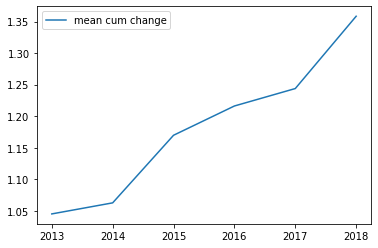

In [9]:
# Plot the mean and median cumulative % change for all gentrified geoids
fig, ax = plt.subplots((7, 7))
sns.(years[1:], np.mean(cum_pct, axis=0), label="mean cum change")
#plt.plot(years[1:], np.mean(med_cum_pct, axis=0), label="median cum change")
plt.legend()

In [25]:
# Extract mean, median and std prices for no-gentrified geoids
years = np.arange(2012, 2019)

stats = {}

for geoid in nData.geoid.unique():
    #stats[geoid] = []
    filled = True
    year_d = []
    for year in years:
        stat = {}
        vals = nData[(nData.geoid == geoid) & (nData.report_year == year)].market_value_per_sqft.values
        if len(vals) > 0:
            stat["std"] = np.std(vals)
            stat["mean"] = np.mean(vals)
            stat["median"] = np.median(vals)
        else:
            stat["std"] = 0
            stat["mean"] = 0
            stat["median"] = 0
            filled = False
            break
        year_d.append(stat)
    if filled:
        stats[geoid] = year_d

In [26]:
# Calculate % change per year per geoid
dchanges = []
dmedchanges = []

# % change year on year
for ug in stats.keys():
    mean = plotter(stats[ug], "mean")
    pct_change = np.diff(mean) / mean[1:]
    dchanges.append(pct_change)
    median = plotter(stats[ug], "median")
    pct_change = np.diff(median) / median[1:]
    dmedchanges.append(pct_change)

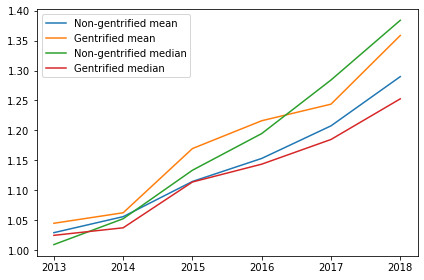

In [27]:
dcum_pct = []
med_dcum_pct = []

# Plot the median and mean cumulative % change, average per geoid

for a, g, m in zip(dchanges, stats.keys(), dmedchanges):
    dcum_pct.append((a+1).cumprod())
    med_dcum_pct.append((m+1).cumprod())
plt.plot(years[1:], np.mean(dcum_pct, axis=0), label="Non-gentrified mean")
plt.plot(years[1:], np.mean(cum_pct, axis=0), label="Gentrified mean")
plt.plot(years[1:], np.mean(med_cum_pct, axis=0), label="Non-gentrified median")
plt.plot(years[1:], np.mean(med_dcum_pct, axis=0), label="Gentrified median")
plt.legend()
plt.tight_layout()

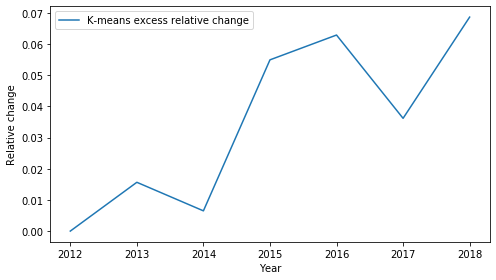

In [31]:
# Plot excess increase of gentrified geoid over non-gentrified
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(years, np.insert(np.mean(cum_pct, axis=0) - np.mean(dcum_pct, axis=0), 0, 0), label="K-means excess relative change")
#plt.plot(years[1:], np.mean(med_cum_pct, axis=0) - np.mean(med_dcum_pct, axis=0), label="Median gentrified excess increase")
plt.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Relative change")
plt.tight_layout()
plt.savefig("k_means_excess_rchange.png")

Probably the most interest plot here. Looking at the mean excess - the blue line - we see that % change is effectively on par and gentrified areas only experience a visually significant excess growth after 2016. Next parts explore why this may be. 

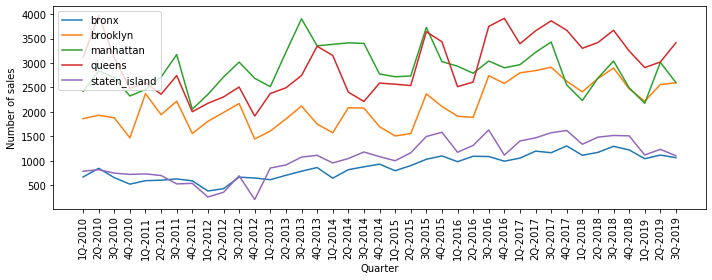

In [49]:
# What happens from 2016-2018?
# Look at number of property sales ->
# Sales data from: https://ny.curbed.com/2019/12/13/21009872/nyc-home-value-2010s-manhattan-apartments
pSales = pd.read_csv("property_sales.txt")
pSales.columns = ["period", "bronx", "brooklyn", "manhattan", "queens", "staten_island"]

# Plot the number of sales per quarter from Q1 2010 to Q3 2019. 
fig, ax = plt.subplots(figsize=(10, 4))
for col in pSales.columns[1:]:
    ax.plot(pSales.period, pSales[col], label=col)
plt.legend()
plt.xticks(rotation=90)
ax.set_ylabel("Number of sales")
ax.set_xlabel("Quarter")
plt.tight_layout()
plt.savefig("figs/sales_by_borough_per_quarter.png")

Manhattan more or less leads the way till 2015/2016 after which Queens takes over as the borough with most sales. https://ny.curbed.com/2019/12/13/21009872/nyc-home-value-2010s-manhattan-apartments attribute this to the lack of available housing in Manhattan as available plots of land for construciton are scarce and the high cost of land encourages builders to construct high-end, expensive housing. This sent people to buy in other boroughs - mainly Queens. We look at % sales growth next. 

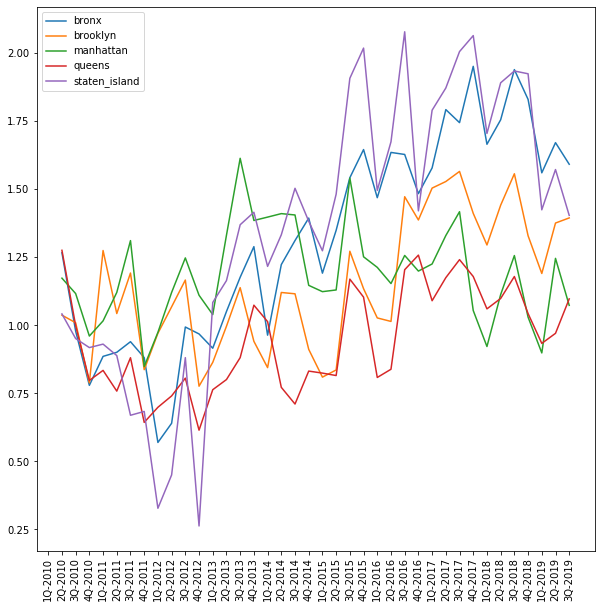

In [26]:
# Cumulative % increase in sales
fig, ax = plt.subplots(figsize=(10, 10))
for col in pSales.columns[1:]:
    ax.plot(pSales.period, (pSales[col].pct_change()+1).cumprod(), label=col)
plt.legend()
plt.xticks(rotation=90)
plt.show()

The boroughs with the least sales see the most growth - the Bronx and Staten Island outpace the others in growth in sales, yet are dwarfed in actual sale numbers. 

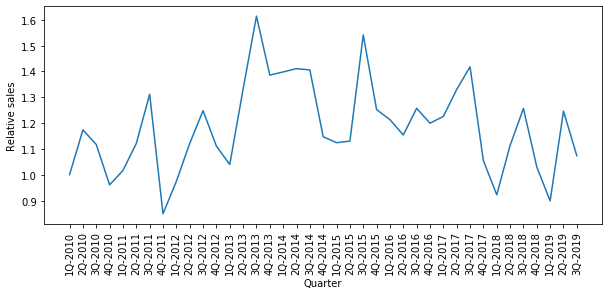

In [41]:
# Looking at Manhattan sales specifically.
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(pSales.period, (pSales.manhattan.pct_change()+1).cumprod().replace(np.nan, 1))
plt.xticks(rotation=90)
ax.set_xlabel("Quarter")
ax.set_ylabel("Relative sales")
plt.show()

Manhattan sees almost no growth in sales, further confirming the lack of available properties. The mid 2010's see the high point in number of sales with sales returning to 2010 levels by 2018. 2018 in fact saw a crash in real eastate in Manhattan (https://www.cnbc.com/2019/01/02/manhattan-real-estate-closes-2018-as-worst-year-since-financial-crisis.html) with an oversupply of high end apartments/flats/condos and a reduction in interest from foreign buyers. 

In [43]:
# Look at sales changes year on year for the period 2012-2018
ySales = pSales.copy()
ySales.loc[-1] = [0]*ySales.shape[1] # Add a buffer row as 2019 is incomplete
ySales = ySales.rolling(4).sum().dropna()
ySales = ySales.iloc[::4, :] # Select every fourth year (calendar year)
ySales = ySales.iloc[2:9] # Select 2012-2018
ySales.index = np.arange(2012, 2019)

In [44]:
ySales

,bronx,brooklyn,manhattan,queens,staten_island
2012,2116.0,7411.0,10779.0,8905.0,1507.0
2013,2957.0,7334.0,12997.0,10958.0,3947.0
2014,3264.0,7432.0,12975.0,10363.0,4262.0
2015,3822.0,7543.0,12215.0,12184.0,5240.0
2016,4147.0,9123.0,11673.0,12795.0,5230.0
2017,4715.0,11186.0,12168.0,14591.0,6064.0
2018,4797.0,10466.0,10460.0,13643.0,5846.0


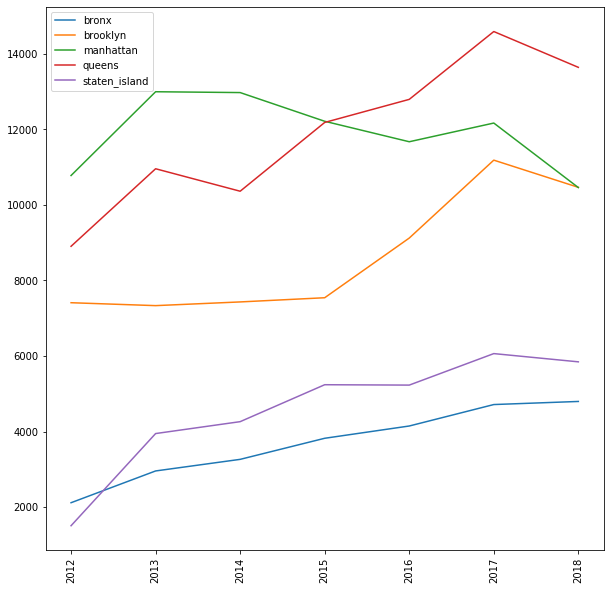

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
for col in ySales.columns:
    ax.plot(ySales.index, ySales[col], label=col)
plt.legend()
plt.xticks(rotation=90)
plt.show()

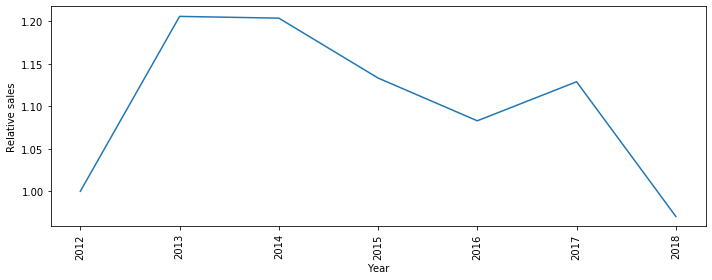

In [50]:
# Look at % change in sales year on year for Manhattan
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ySales.index, (ySales.manhattan.pct_change()+1).cumprod().replace(np.nan, 1))
plt.xticks(rotation=90)
ax.set_xlabel("Year")
ax.set_ylabel("Relative sales")
plt.tight_layout()
plt.savefig("figs/manhattan_relative_sales.png")


The number of sales in Manhattan has decreased since 2013 (its peak) and returning to slightly below 2012 levels. But does this impact the value of Manhattan real estate?

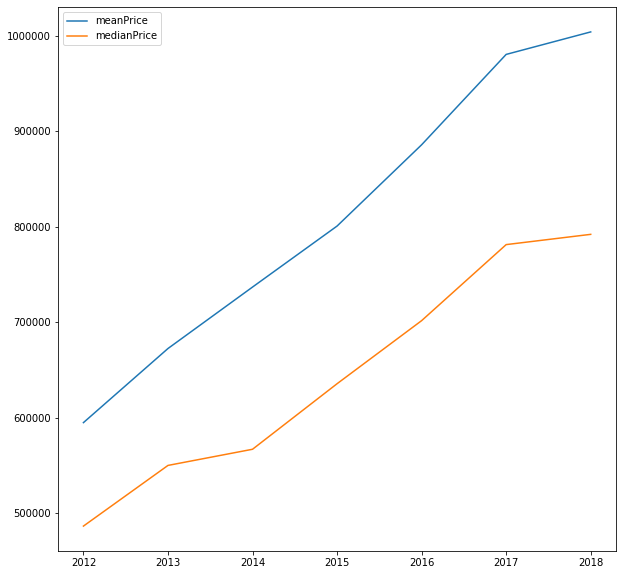

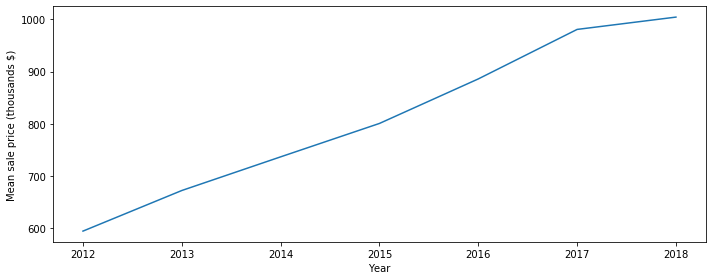

In [56]:
# Mean and median sale price in Manhattan: https://ny.curbed.com/2019/12/13/21009872/nyc-home-value-2010s-manhattan-apartments
mPrices = pd.read_csv("manhattan_prices.csv")
mPrices.loc[-1] = [0]*mPrices.shape[1] # Add a buffer row as 2019 is incomplete
mPrices = mPrices.rolling(4).mean().dropna()
mPrices = mPrices.iloc[::4, :] # Select every fourth year (calendar year)
mPrices = mPrices.iloc[2:9] # Select 2012-2018
mPrices.index = np.arange(2012, 2019)
mPrices.columns = ["meanPrice", "medianPrice"]
fig, ax = plt.subplots(figsize=(10, 10))
mPrices.plot(ax=ax)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mPrices.meanPrice/1000)
ax.set_xlabel("Year")
ax.set_ylabel("Mean sale price (thousands $)")
plt.tight_layout()
plt.savefig("manhattan_mean_sale_price.png")

Text(0, 0.5, 'Market value (million $)')

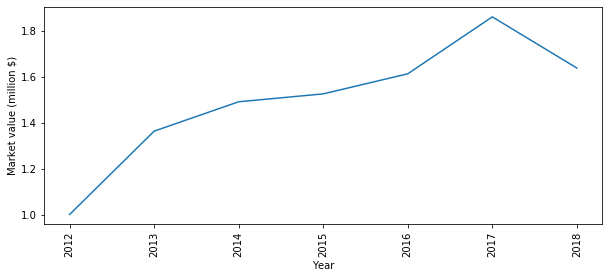

In [59]:
# Look at % change in sales year on year for Manhattan
fig, ax = plt.subplots(figsize=(10, 4))
#ax.plot(ySales.index, ySales.manhattan * mPrices.meanPrice / 1e6)
ax.plot(ySales.index, ((ySales.manhattan * mPrices.meanPrice).pct_change()+1).replace(np.nan, 1).cumprod())


plt.xticks(rotation=90)
ax.set_xlabel("Year")
ax.set_ylabel("Market value (million $)")
#plt.savefig("figs/manhattan_property_market.png")



Both the mean and median sale prices of proeprties in Manhattan show no decrease over the period with a slightly lower increase in price in 2018 only. The value of Manhattan real estate hasn't gone down, although the number of sales have. The demand for affordable condos in Manhattan has arguably increased as the gentrified tracts see a higher % increase in price per SqFt than non-gentrified areas. 

In [33]:
# Link between sales and overall manhattan prices ->
np.corrcoef(ySales.manhattan.values, mPrices.meanPrice.values)

array([[ 1.        , -0.26332014],
       [-0.26332014,  1.        ]])

In [34]:
# Link between sales and gentrified price change % ->
np.corrcoef(ySales.manhattan.values, np.insert(np.mean(cum_pct, axis=0), 0, 1, axis=0))

array([[ 1.       , -0.4265929],
       [-0.4265929,  1.       ]])

In [35]:
# Link between sales and non-gentrified price change % ->
sales_pct = (ySales.manhattan.pct_change()+1).cumprod().values
sales_pct[0] = 1
np.corrcoef(sales_pct, np.insert(np.mean(dcum_pct, axis=0), 0, 1, axis=0))

array([[ 1.        , -0.42759814],
       [-0.42759814,  1.        ]])

In [36]:
# Link between sales change % and gentrified price change % ->
sales_pct = (ySales.manhattan.pct_change()+1).cumprod().values
sales_pct[0] = 1
np.corrcoef(sales_pct, np.insert(np.mean(cum_pct, axis=0), 0, 1, axis=0))

array([[ 1.       , -0.4265929],
       [-0.4265929,  1.       ]])

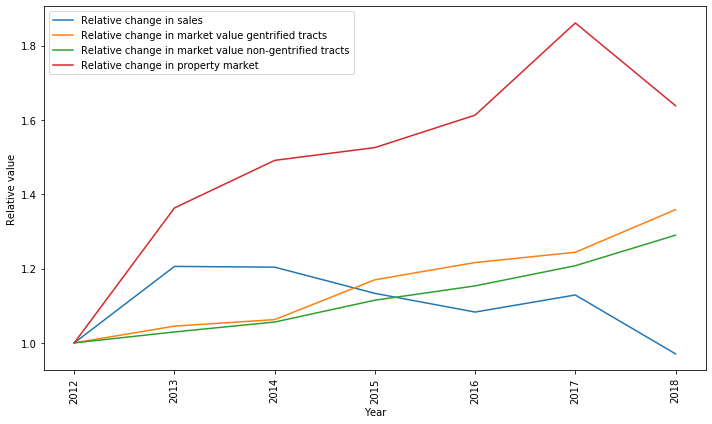

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
sales_pct = (ySales.manhattan.pct_change()+1).cumprod().values
sales_pct[0] = 1
mean_price = (mPrices.medianPrice.pct_change()+1).cumprod().values
mean_price[0] = 1
ax.plot(ySales.index, sales_pct, label="Relative change in sales")
ax.plot(ySales.index, np.insert(np.mean(cum_pct, axis=0), 0, 1), label="Relative change in market value gentrified tracts")
ax.plot(ySales.index, np.insert(np.mean(dcum_pct, axis=0), 0, 1), label="Relative change in market value non-gentrified tracts")
ax.plot(ySales.index, ((ySales.manhattan * mPrices.meanPrice).pct_change()+1).replace(np.nan, 1).cumprod(), label="Relative change in property market")
plt.xticks(rotation=90)
plt.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Relative value")
plt.tight_layout()
plt.savefig("figs/k_means_summary.png")

This summarises the work so far nicely, as the supply of (more-affordable) condos has dwindled during 2013-2015, in 2016 and onwards the tracts identified as gentrified have seen far more demand leading to a higher increase in price per sq ft than the non-gentrified areas. Gentrification, in Manhattan at least, occured because the market was saturated with high value condos leading to lack of investor interest, and more reasonably priced areas see more interest from less wealthy investors. 

In [38]:
# Compute beta for gentrified tracts
np.cov(np.insert(np.mean(cum_pct, axis=0), 0, 1), np.insert(np.mean(dcum_pct, axis=0), 0, 1))[0][1] / np.var(np.insert(np.mean(dcum_pct, axis=0), 0, 1))
                                             

1.4281143985899414

Finally, we look at eviction rates in 2017 and 2018 for Manhattan. 

In [61]:
evictions = pd.read_csv("Evictions.csv") 
evictions.columns = ["court_index", "docket", "address", "apartment_num", "date", "marshall_forename", "marshall_surname", "type", "borough", "zip"]
evictions = evictions[["court_index", "address", "apartment_num", "date", "type", "borough"]]
evictions.date = evictions.date.apply(lambda x: int(str(x).split("/")[-1])) # Find eviction year
evictions = evictions[evictions.date <= 2018]
evictions = evictions[evictions.type == "Residential"] # Only residential evictions
ManhattanEvictions = evictions[evictions.borough == "MANHATTAN"] # Manhattan evictions, ~5500 altogether
ManhattanEvictions

,court_index,address,apartment_num,date,type,borough
13,55690/17,2 WEST 120 STREET,5M,2017,Residential,MANHATTAN
22,64399/17,545 EDGECOMBE AVENUE,5D,2018,Residential,MANHATTAN
25,74028/17,430 EAST 6TH STREET,8E,2018,Residential,MANHATTAN
56,N070361/15,607 WEST 137 STREET,63,2017,Residential,MANHATTAN
59,87506/15,565 WEST 192ND STREET,1D,2017,Residential,MANHATTAN
...,...,...,...,...,...,...
66306,51484/17,173 WEST 141ST ST.,2A,2017,Residential,MANHATTAN
66307,74618/17,2906 FREDERICK DOUGLASS BLVD. AKA 272 WEST 154...,3C,2018,Residential,MANHATTAN
66311,54169/16,501 W 143 STREET,22,2018,Residential,MANHATTAN
66313,79268/16,207 DYCKMAN STREET,34,2018,Residential,MANHATTAN


In [62]:
# Match Manhattan evictions address to geoid

# Load up Manhattan evictions with geoids from file
ManhattanEvictions = pd.read_pickle("manhattan_evictions.pkl")
ManhattanEvictions.geoid = ManhattanEvictions.geoid.astype(int)
ManhattanEvictions = ManhattanEvictions[ManhattanEvictions.geoid > 0] # Remove areas with no geoids present

# Remove block number for geoid
ManhattanEvictions.geoid = ManhattanEvictions.geoid.apply(lambda x: int(str(x)[:-4])) 

In [63]:
GentrifiedEvictions = ManhattanEvictions[ManhattanEvictions.geoid.isin(gentrified.geoid.unique())]
NonGentrifiedEvictions = ManhattanEvictions[~ManhattanEvictions.geoid.isin(gentrified.geoid.unique())]



449 evictions in 10 gentrified areas and 5399 evictions in 268 non-gentrified areas i.e. around double the eviction rate per goid for gentrified areas over 2017 and 2018. 

In [64]:
# Find average evictions for gentrified and non-gentrified tracts per year
gentrified_evictions = {}
non_gentrified_evictions = {}

for year in [2017, 2018]:
    gentrified_evictions[year] = len(GentrifiedEvictions[GentrifiedEvictions.date == year])/len(GentrifiedEvictions.geoid.unique())
    non_gentrified_evictions[year] = len(NonGentrifiedEvictions[NonGentrifiedEvictions.date == year])/len(NonGentrifiedEvictions.geoid.unique())
    
    

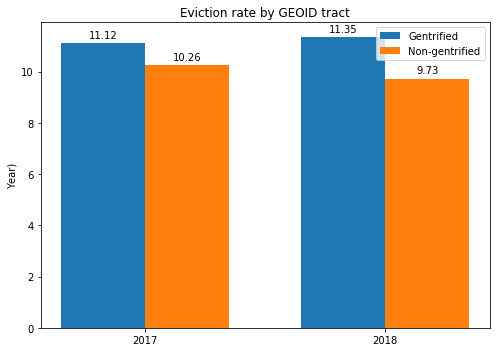

In [68]:
labels = ['2017', '2018']
gentrified_data = [gentrified_evictions[2017], gentrified_evictions[2018]]
non_gentrified_data = [non_gentrified_evictions[2017], non_gentrified_evictions[2018]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(x - width/2, gentrified_data, width, label='Gentrified')
rects2 = ax.bar(x + width/2, non_gentrified_data, width, label='Non-gentrified')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Evictions')
ax.set_title('Eviction rate by GEOID tract')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
ax.set_ylabel("Year)")
plt.tight_layout()
plt.savefig("figs/k_means_evictions.png")

In the year following the maximum peak in gentrified geoids prices, we see a clear increase the in average number of evictions per gentrified geoid in Manhattan. This suggests that there are relatively more people being evicted from their homes in these areas, likely due ot being priced out of the are -- thus furthering the process of gentrification. 

NOTES:
    WE ignore the effects of rent stabilisation in this analysis